# CHAPTER 7.2

### Implementing an image captioning network

this notebook is prepared with the help of https://github.com/PacktPublishing/Tensorflow-2.0-Computer-Vision-Cookbook/tree/master/ch7 github repo. This is just a quick review about subject and notes for myself. If you want to reach original codes, you can check it. We will use https://www.kaggle.com/adityajn105/flickr8k. dataset. In this dataset, we have 8091 images,and a txt file which describe each images about 5 times in different sentences.

In [1]:
import glob
import pathlib
import pickle

import os

from tensorflow.keras.preprocessing.image import *
from string import punctuation

import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.sequence import \
    pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm


In [2]:
#our main class to create datasets and feature extraction
class ImageCaptionFeatureExtractor(object):
    def __init__(self,
                 output_path='.',
                 start_token='beginsequence',
                 end_token='endsequence',
                 feature_extractor=None,
                 input_shape=(224, 224, 3)):
        self.input_shape = input_shape

        if feature_extractor is None:
            input = Input(shape=input_shape)
            self.feature_extractor = VGG16(input_tensor=input,
                                           weights='imagenet',
                                           include_top=False)
        else:
            self.feature_extractor = feature_extractor

        self.output_path = output_path
        self.start_token = start_token
        self.end_token = end_token
        self.tokenizer = Tokenizer()
        self.max_seq_length = None

    def extract_image_features(self, image_path):
        image = load_img(image_path,
                         target_size=self.input_shape[:2])
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)

        return self.feature_extractor.predict(image)[0]

    def _clean_captions(self, captions):
        def remove_punctuation(word):
            translation = str.maketrans('', '',
                                        punctuation)
            return word.translate(translation)

        def is_valid_word(word):
            return len(word) > 1 and word.isalpha()

        cleaned_captions = []
        for caption in captions:
            caption = caption.lower().split(' ')
            caption = map(remove_punctuation, caption)
            caption = filter(is_valid_word, caption)

            cleaned_caption = f'{self.start_token} ' \
                              f'{" ".join(caption)} ' \
                              f'{self.end_token}'
            cleaned_captions.append(cleaned_caption)

        return cleaned_captions

    def _get_max_seq_length(self, captions):
        max_sequence_length = -1

        for caption in captions:
            caption_length = len(caption.split(' '))
            max_sequence_length = max(max_sequence_length,
                                      caption_length)

        return max_sequence_length

    def extract_features(self, images_path, captions):
        assert len(images_path) == len(captions)

        captions = self._clean_captions(captions)
        self.max_seq_length = self._get_max_seq_length(captions)
        self.tokenizer.fit_on_texts(captions)

        data_mapping = {}
        print('\nExtracting features...')
        for i in tqdm(range(len(images_path))):
            image_path = images_path[i]
            caption = captions[i]

            feats = self.extract_image_features(image_path)

            image_id = image_path.split(os.path.sep)[-1]
            image_id = image_id.split('.')[0]

            data_mapping[image_id] = {
                'features': feats,
                'caption': caption
            }

        out_path = f'{self.output_path}/data_mapping.pickle'
        with open(out_path, 'wb') as f:
            pickle.dump(data_mapping, f, protocol=4)

        self._create_sequences(data_mapping)

    def _create_sequences(self, mapping):
        num_classes = len(self.tokenizer.word_index) + 1

        in_feats = []
        in_seqs = []
        out_seqs = []

        print('\nCreating sequences...')
        for _, data in tqdm(mapping.items()):
            feature = data['features']
            caption = data['caption']

            seq, = self.tokenizer.texts_to_sequences([caption])

            for i in range(1, len(seq)):
                input_seq = seq[:i]
                input_seq, = pad_sequences([input_seq],
                                           self.max_seq_length)

                # ONE HOT ENCODING
                out_seq = seq[i]
                out_seq = to_categorical([out_seq],
                                         num_classes)[0]

                in_feats.append(feature)
                in_seqs.append(input_seq)
                out_seqs.append(out_seq)

        file_paths = [
            f'{self.output_path}/input_features.pickle',
            f'{self.output_path}/input_sequences.pickle',
            f'{self.output_path}/output_sequences.pickle']
        sequences = [in_feats,
                     in_seqs,
                     out_seqs]

        for path, seq in zip(file_paths, sequences):
            with open(path, 'wb') as f:
                pickle.dump(np.array(seq), f, protocol=4)


In [3]:
BASE_PATH = (pathlib.Path.home() / '.keras' / 'datasets' /
             'flickr8k')
IMAGES_PATH = str(BASE_PATH / 'Images')
CAPTIONS_PATH = str(BASE_PATH / 'captions.txt')
OUTPUT_PATH = '.'

In [4]:
def load_paths_and_captions():
    image_paths = list(glob.glob(f'{IMAGES_PATH}/*.jpg'))

    with open(f'{CAPTIONS_PATH}', 'r') as f:
        text = f.read()
        lines = text.split('\n')

    mapping = {}
    for line in lines:
        if '.jpg' not in line:
            continue
        tokens = line.split(',', maxsplit=1)

        if len(line) < 2:
            continue

        image_id, image_caption = tokens
        image_id = image_id.split('.')[0]

        captions_per_image = mapping.get(image_id, [])
        captions_per_image.append(image_caption)

        mapping[image_id] = captions_per_image

    all_captions = []
    for image_path in image_paths:
        image_id = image_path.split('\\')[-1].split('.')[0]
        all_captions.append(mapping[image_id][0])

    return image_paths, all_captions

In [5]:
image_paths, all_captions = load_paths_and_captions()

In [6]:
len(all_captions)

8091

In [7]:
extractor_model = VGG16(weights='imagenet')
inputs = extractor_model.inputs
outputs = extractor_model.layers[-2].output
extractor_model = Model(inputs=inputs, outputs=outputs)

In [8]:
extractor_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
outputs

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'fc2')>

In [10]:
def build_network(vocabulary_size,
                  max_sequence_length,
                  input_shape=(4096,)):
    feature_inputs = Input(shape=input_shape)
    x = Dropout(rate=0.5)(feature_inputs)
    x = Dense(units=256)(x)
    feature_output = ReLU()(x)

    sequence_inputs = Input(shape=(max_sequence_length,))
    y = Embedding(input_dim=vocabulary_size,
                  output_dim=256,
                  mask_zero=True)(sequence_inputs)
    y = Dropout(rate=0.5)(y)
    sequence_output = LSTM(units=256)(y)

    z = Add()([feature_output, sequence_output])
    z = Dense(units=256)(z)
    z = ReLU()(z)
    z = Dense(units=vocabulary_size)(z)
    outputs = Softmax()(z)

    return Model(inputs=[feature_inputs, sequence_inputs],
                 outputs=outputs)

In [11]:
def get_word_from_index(tokenizer, index):
    return tokenizer.index_word.get(index, None)


def produce_caption(model,
                    tokenizer,
                    image,
                    max_sequence_length):
    text = 'beginsequence'
    image = np.expand_dims(image, axis=0)

    for i in range(max_sequence_length):
        sequence = tokenizer.texts_to_sequences([text])[0]
        sequence = pad_sequences([sequence],
                                 maxlen=max_sequence_length)

        prediction = model.predict([[image], sequence])
        index = np.argmax(prediction)

        word = get_word_from_index(tokenizer, index)

        if word is None:
            break

        text += f' {word}'

        if word == 'endsequence':
            break

    return text

### !!! I added a code line in produce_caption function, because the dimension of image was not correct!!!

In [12]:
extractor = ImageCaptionFeatureExtractor(
    feature_extractor=extractor_model,
    output_path=OUTPUT_PATH)

In [13]:
extractor.extract_features(image_paths, all_captions)


Extracting features...


100%|██████████| 8091/8091 [07:23<00:00, 18.26it/s]



Creating sequences...


100%|██████████| 8091/8091 [00:03<00:00, 2509.71it/s]


In [14]:
pickled_data = []
for p in [f'{OUTPUT_PATH}/input_features.pickle',
          f'{OUTPUT_PATH}/input_sequences.pickle',
          f'{OUTPUT_PATH}/output_sequences.pickle']:
    with open(p, 'rb') as f:
        pickled_data.append(pickle.load(f))

input_feats, input_seqs, output_seqs = pickled_data

In [15]:
input_feats.shape

(82621, 4096)

In [16]:
input_seqs.shape

(82621, 30)

In [17]:
output_seqs.shape

(82621, 4476)

In [18]:
(train_input_feats, test_input_feats,
 train_input_seqs, test_input_seqs,
 train_output_seqs,
 test_output_seqs) = train_test_split(input_feats,
                                      input_seqs,
                                      output_seqs,
                                      train_size=0.8,
                                      random_state=9)

In [19]:
vocabulary_size = len(extractor.tokenizer.word_index) + 1

In [20]:
print(vocabulary_size)

4476


In [21]:
model = build_network(vocabulary_size,
                      extractor.max_seq_length)
model.compile(loss='categorical_crossentropy',
              optimizer='adam')

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 30, 256)      1145856     ['input_3[0][0]']                
                                                                                            

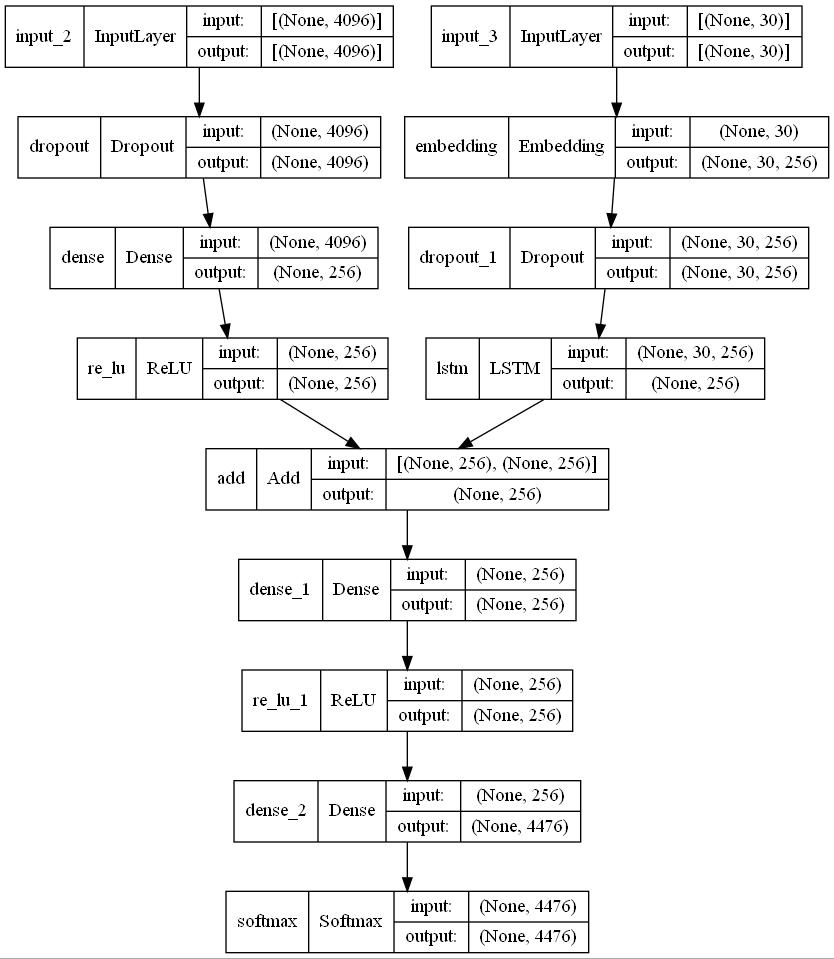

In [23]:
from tensorflow.keras.utils import plot_model
from PIL import Image
plot_model(model, show_shapes=True, show_layer_names=True, to_file='captioning_model_2th_notebook.jpg')

In [24]:
checkpoint_path = ('model-ep{epoch:03d}-loss{loss:.3f}-'
                   'val_loss{val_loss:.3f}.h5')
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

checkpoints = sorted(list(glob.glob('./*.h5')), reverse=True)

In [25]:
if len(checkpoints) > 0:
    model = load_model(checkpoints[0])
else:
    EPOCHS = 30
    model.fit(x=[train_input_feats, train_input_seqs],
              y=train_output_seqs,
              epochs=EPOCHS,
              callbacks=[checkpoint],
              validation_data=([test_input_feats, test_input_seqs],
                               test_output_seqs))

Epoch 1/30
2066/2066 [==============================] - ETA: 0s - loss: 5.1351
Epoch 00001: val_loss improved from inf to 4.55922, saving model to model-ep001-loss5.135-val_loss4.559.h5
2066/2066 [==============================] - 510s 245ms/step - loss: 5.1351 - val_loss: 4.5592
Epoch 2/30


C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2066/2066 [==============================] - ETA: 0s - loss: 4.2736
Epoch 00002: val_loss improved from 4.55922 to 4.34077, saving model to model-ep002-loss4.274-val_loss4.341.h5
2066/2066 [==============================] - 498s 241ms/step - loss: 4.2736 - val_loss: 4.3408
Epoch 3/30
2066/2066 [==============================] - ETA: 0s - loss: 3.9233
Epoch 00003: val_loss improved from 4.34077 to 4.25993, saving model to model-ep003-loss3.923-val_loss4.260.h5
2066/2066 [==============================] - 516s 250ms/step - loss: 3.9233 - val_loss: 4.2599
Epoch 4/30
2066/2066 [==============================] - ETA: 0s - loss: 3.6873
Epoch 00004: val_loss did not improve from 4.25993
2066/2066 [==============================] - 511s 247ms/step - loss: 3.6873 - val_loss: 4.2874
Epoch 5/30
2066/2066 [==============================] - ETA: 0s - loss: 3.5150
Epoch 00005: val_loss did not improve from 4.25993
2066/2066 [==============================] - 538s 261ms/step - loss: 3.5150 - val_loss

KeyboardInterrupt: 

In [26]:
def evaluate_model(model, features, captions, tokenizer,
                   max_seq_length):
    actual = []
    predicted = []

    for feature, caption in zip(features, captions):
        generated_caption = produce_caption(model,
                                            tokenizer,
                                            feature,
                                            max_seq_length)

        actual.append([caption.split(' ')])
        predicted.append(generated_caption.split(' '))

    for index, weights in enumerate([(1.0, 0, 0, 0),
                                     (0.5, 0.5, 0, 0),
                                     (0.3, 0.3, 0.3, 0),
                                     (0.25, 0.25, 0.25, 0.25)],
                                    start=1):
        b_score = corpus_bleu(actual, predicted, weights)
        print(f'BLEU-{index}: {b_score}')

In [27]:
model = load_model('model-ep003-loss3.923-val_loss4.260.h5')

In [28]:
with open(f'{OUTPUT_PATH}/data_mapping.pickle', 'rb') as f:
    data_mapping = pickle.load(f)

feats = [v['features'] for v in data_mapping.values()]
captions = [v['caption'] for v in data_mapping.values()]


In [29]:
captions

['beginsequence child in pink dress is climbing up set of stairs in an entry way endsequence',
 'beginsequence black dog and spotted dog are fighting endsequence',
 'beginsequence little girl covered in paint sits in front of painted rainbow with her hands in bowl endsequence',
 'beginsequence man lays on bench while his dog sits by him endsequence',
 'beginsequence man in an orange hat starring at something endsequence',
 'beginsequence child playing on rope net endsequence',
 'beginsequence black and white dog is running in grassy garden surrounded by white fence endsequence',
 'beginsequence dog shakes its head near the shore red ball next to it endsequence',
 'beginsequence boy smiles in front of stony wall in city endsequence',
 'beginsequence black dog leaps over log endsequence',
 'beginsequence brown and white dog is running through the snow endsequence',
 'beginsequence man in hat is displaying pictures next to skier in blue hat endsequence',
 'beginsequence collage of one per

In [30]:
evaluate_model(model,
               features=feats,
               captions=captions,
               tokenizer=extractor.tokenizer,
               max_seq_length=extractor.max_seq_length)

BLEU-1: 0.3584707195779536
BLEU-2: 0.16531892034410328
BLEU-3: 0.11589414177194503
BLEU-4: 0.051474221036828804
